# 16대 젠더 관련 의안 분석

### 2000.05.30 ~ 2004.05.29 / 김대중, 노무현 정부

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
from gensim import models
import fasttext.util
from sklearn.cluster import AgglomerativeClustering
from konlpy.tag import Okt
import logging
import hanja
from krwordrank.hangle import normalize
%matplotlib inline

In [2]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


In [3]:
bill_df1 = pd.read_csv('/Users/harampark/Documents/research/gender-bill-analysis/data/selenium-data/16대 국회 의안정보.csv', 
                      parse_dates=['제안일자', '의결일자'])
bill_df2 = pd.read_csv('/Users/harampark/Documents/research/gender-bill-analysis/data/selenium-data/16대 국회 의안정보(2).csv', 
                      parse_dates=['제안일자', '의결일자'])

bill_df = pd.concat([bill_df1, bill_df2]).drop_duplicates()
bill_df.shape

(2507, 10)

In [4]:
bill_df.head(1)

,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자
0,163170,경기북도설치등에관한법률안(홍문종의원등 20인),2004-03-03,의원,2004-05-29,임기만료폐기,제16대 (2000~2004) 제246회,"['■ 제안이유경기북부지역은 한반도의 중심에 있으며, 21세기 남북통일의 전초기지로...",행정자치위원회,"['홍문종', '강인섭', '권영세', '김황식', '목요상', '박상규', '박진..."


In [5]:
def preprocessing(text): 
    text = text.replace('■ 제안이유', ' ').replace('■ 주요골자', ' ').replace('■ 기타사항', ' ')
    text = text.replace('■ 위원회 수정사항□ 수정이유',' ').replace('■ 제안경위',' ').replace('[',' ').replace(']',' ')
    text = text.replace('녀성', '여성').replace('로동', '노동').replace('륜리','윤리').replace('녀비','여비')
    text = text.replace("'",' ').replace('□ 수정이유',' ').replace('및','').replace('주요골자', ' ').replace('■ 수정사항',' ')
    return text

def clean_name(text): 
    text = text.split('(')[0]
    return text.strip()

In [6]:
%time bill_df['제안이유'] = bill_df['제안이유'].apply(lambda x: hanja.translate(x, 'substitution'))
%time bill_df['제안이유'] = bill_df['제안이유'].apply(preprocessing)
%time bill_df['의안명'] = bill_df['의안명'].apply(clean_name)

CPU times: user 2.4 s, sys: 8.67 ms, total: 2.4 s
Wall time: 2.42 s
CPU times: user 24.3 ms, sys: 1.35 ms, total: 25.7 ms
Wall time: 25.6 ms
CPU times: user 1.65 ms, sys: 80 µs, total: 1.73 ms
Wall time: 1.69 ms


In [7]:
bill_df.head(1)

,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자
0,163170,경기북도설치등에관한법률안,2004-03-03,의원,2004-05-29,임기만료폐기,제16대 (2000~2004) 제246회,"경기북부지역은 한반도의 중심에 있으며, 21세기 남북통일의 전초기지로 지리적으...",행정자치위원회,"['홍문종', '강인섭', '권영세', '김황식', '목요상', '박상규', '박진..."


## 젠더 관련 의안만 추리기

In [8]:
# 여성위원회 존재!
bill_df['소관위원회'].unique()

array(['행정자치위원회', '정치개혁특별위원회', '보건복지위원회', '법제사법위원회', '재정경제위원회', '교육위원회',
       '산업자원위원회', '문화관광위원회', '국회운영위원회', '건설교통위원회', '과거사진상규명에관한특별위원회',
       '국방위원회', '농림해양수산위원회', '정무위원회', '환경노동위원회', '과학기술정보통신위원회', '여성위원회',
       '통일외교통상위원회', '정보위원회', '미확정'], dtype=object)

In [9]:
comm = bill_df[bill_df['소관위원회'] == '여성위원회']
comm['의안명'].unique()

array(['가정폭력방지및피해자보호등에관한법률중개정법률안', '여성발전기본법중개정법률안', '성매매방지및피해자보호등에관한법률안'],
      dtype=object)

In [10]:
keyword = r'.*(여성|성범죄|남녀|호주|육아|보육|가부장|강간|정조|간통죄|성폭력|남녀평등|성차별|모성|성접대|낙태|부녀자|퇴폐|남여|미혼모|\
                성희롱|성보호|음란|가족|윤락|위안부|양성평등|양성 평등|스토킹|가정폭력|정신대|청소년|가정폭력|남녀차별|모자보건|출산|모부자\
                공중화장실|공중 화장실|공직선거법|공직 선거법|건강가족기본법|유산|사산|성인지|한부모|모·부자).*'
gender = bill_df[bill_df['의안명'].str.match(keyword) |
           bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
gender = gender.reset_index()
# gender = gender.drop('index',1)
gender.shape

(299, 11)

In [11]:
keyword = r'.*(역차별).*'
gender = bill_df[bill_df['의안명'].str.match(keyword) |
           bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
gender = gender.reset_index()
# gender = gender.drop('index',1)
gender.shape

(0, 11)

In [16]:
gender.head(5)

,index,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자
0,288,162815,산업발전법중개정법률안,2003-10-28,정부,2003-12-22,수정가결,제16대 (2000~2004) 제243회,기업구조조정전문회사가 매입할 수 있는 부실채권의 범위를 확대하여 부실기업의 구...,산업자원위원회,[]
1,290,162813,수산업협동조합법개정법률안,2003-10-28,정부,2004-05-29,임기만료폐기,제16대 (2000~2004) 제243회,부실화된 수산업협동조합의 조속한 경영정상화를 도모하고 향후 부실경영을 예방하기...,농림해양수산위원회,[]
2,292,162811,독점규제및공정거래에관한법률중개정법률안,2003-10-28,정부,2004-05-29,임기만료폐기,제16대 (2000~2004) 제243회,기업경영의 투명성을 제고하고 자유롭고 공정한 시장경쟁을 확보하기 위하여 지주회...,정무위원회,[]
3,408,162668,청년실업해소특별법안,2003-09-22,의원,2004-02-09,수정가결,제16대 (2000~2004) 제243회,최근 국내 제조업체의 해외이전에 따른 산업공동화 현상과 고급인력의 3D업종 등...,환경노동위원회,"['이강두', '이원형', '이한구', '강인섭', '강재섭', '강창성', '강창..."
4,423,162653,국민기초생활보장법중개정법률안,2003-09-16,의원,2004-02-09,대안반영폐기,제16대 (2000~2004) 제243회,차상위계층(준극빈층)은 실제 생활이 국민기초생활보장법상 수급권자와 다름없음에도...,보건복지위원회,"['이원형', '강재섭', '김만제', '김명섭', '박명환', '박시균', '박주..."


In [10]:
x = gender[gender['의안번호'] == 160061]['제안이유'][294]
hanja.translate(x, 'substitution')

'   새 천년의 요구에 맞는 경쟁력있고 효율적인 정부를 구현하기 위하여 국가 핵심力량인 경제정책  인적자원개발정책 분야의 총괄·조정기능을 수행할 부총리 2인을 신설하고, 女성의 사회참여 확대  권익신장을 도모하기 위하여 여성특별위원회를 女성부로 확대·개편하여 女성관련 기능을 강화하려는 것임. 1. 국무총리가 특별히 위임하는 사무를 처리하게 하기 위하여 부총리 2인을 둘 수 있도록 하고, 부총리는 재정경제부장관과 교육인적자원부장관이 각각 겸임하며, 재정경제부장관은 경제정책에 관하여, 교육인적자원부장관은 인적자원개발정책에 관하여 각각 국무총리의 명을 받아 관계각부를 총괄 조정함(안 제19조의2 신설).2. 재정경제부에 국제金융  경제협력업무에 관하여 장관을 보좌하는 1급의 일반직국가공무원 1인을 둘 수 있도록 함 (안 제27조제3항 신설).3. 교육부를 교육인적자원부로 개칭하고, 교육인적자원부에 차관보 1인을 두도록 함(안 제26조제1항  안 제28조 신설).4. 女성특별위원회를 폐지하고 女성부를 신설하되, 여성부는 보건복지부로부터 가정폭력·성폭력 피해자의 보호, 淪락행위 등의 방지업무를 이관받아 女성정책의 기획·종합, 남녀차별의 금지·구제 등 女성의 지위향상에 관한 사무를 담당하도록 함(현행 제18조제1항 내지 제3항 삭제, 안 제42조 신설  부칙 제3조제74항내지 제76항).    마사의 진흥  축산발전을 위하여 한국마사회의 소관을 문화관광부에서 농림부로 이관하고, 일제하 일본군위안부에 대한 생활안정지원업무의 효율적 수행을 위하여 동 업무를 보건복지부소관에서 신설되는 여성부 소관사무로 이관하며, 국무조정실의 원활한 업무수행을 위하여 국무조정실장을 정부위원으로 함.  '

In [11]:
gender[gender['의안명'] == '공중위생관리법중개정법률안']

,index,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자
97,602,162423,공중위생관리법중개정법률안,2003-06-30,의원,2003-12-22,수정가결,제16대 (2000~2004) 제240회,’99년 2월 8일 공중위생법에서 전환된 현행 공중위생관리법은 규제를 완...,보건복지위원회,"['김성순', '김명섭', '김상현', '김일윤', '김태홍', '김홍신', '신기..."
152,2207,161657,공중위생관리법중개정법률안,2002-07-30,위원장,2002-07-31,원안가결,제16대 (2000~2004) 제232회,""" 1. 2000년 11월 21일 심재철 의원이 대표발의한 공중위생관리법중개정법률...",보건복지위원회,[]
226,2995,160666,공중위생관리법중개정법률안,2001-03-12,의원,2002-07-31,대안반영폐기,제16대 (2000~2004) 제219회,현행 공중위생관리법은 규제완화 보건위생과 관련한 부패 방지의 차원에서 ...,보건복지위원회,"['정범구', '김경천', '김덕배', '남궁석', '송영길', '유재규', '이낙..."
264,242,160364,공중위생관리법중개정법률안,2000-11-21,의원,2002-07-31,대안반영폐기,제16대 (2000~2004) 제215회,현행 공중위생관리법은 규제완화 보건위생 관련 부패방지 차원에서 공중위생영업을...,보건복지위원회,"['심재철', '강재섭', '김기춘', '김정숙', '김찬우', '목요상', '박시..."


In [12]:
for row in gender[gender['의안명'] == '공중위생관리법중개정법률안']['제안이유']:
    print(row)

      ’99년 2월 8일 공중위생법에서 전환된 현행 공중위생관리법은 규제를 완화하여 영업의 자율성을 제고하고 업소간 무한 경쟁을 도입하여 소비자에게 양질의 서비스를 혜택으로 돌아가게 하는데 그 입법취지가 있었으나 영업시간 제한, 위생교육관련 규정 등을 폐지 또는 완화하는 등 필요적절한 장치가 미흡함으로 말미암아 건전영업이 조장되지 않고 오히려 비위생 또는 퇴폐영업을 방치하고 있다는 지적을 받아왔음.특히, 공중위생영업소에 대한 영업시간 제한 폐지로 말미암아 불필요한 에너지를 소모시키고, 업소간 과당경쟁이 심화되며 퇴폐영업의 소지를 확대시키고 있는 실정으로, 이러한 문제점을 개선하기 위하여 공중위생영업소에 대한 영업시간을 제한할 수 있는 근거규정을 마련하려는 것임(안 제9조의2 신설).또한 현행법상 공중위생영업자중 신규개설자  행정처분자에 한하여 실시하고 있는 위생교육을 공중위생영업소에 종사하는 자를 대상으로 매년 실시하도록 함으로써, 신기술 정보와 위생관련법규에 대한 교육  자질함양을 위한 적절한 소양교육의 기회를 제공하여 준법정신 함양  건전영업 풍토를 조성하려는 것임(안 제17조제1항).   수정 공중위생영업자에 대하여 영업시간을 제한할 수 있는 주체를 ‘시·도지사  시장·군수·구청장’에서 ‘시·도지사’로 수정하였고, 공중위생영업종사자까지 위생교육을 매년 받도록 하는 것은 과도한 부담을 줄 수 있으므로 공중위생영업자만 받도록 수정하였으며, 공중위생영업자에게 새로운 의무부과를 하는 것으로 개정하였기 때문에 법적용대상자에게 개정된 법내용의 인지기간을 줄뿐만 아니라 관련하위입법의 마련에 필요한 시간을 확보하기 위하여 ‘공포한 날부터’시행하도록 하고 있는 것을 ‘공포후 6월이 경과한 날부터’시행하도록 수정하였음.  
 " 1. 2000년 11월 21일 심재철 의원이 대표발의한 공중위생관리법중개정법률안, 2001년 3월 12일 정범구 의원이 대표발의한 공중위생관리법중개정법률안, 2001년 11월 16일 김성순의원이 대표발의한 공중위생관리법중개정법률안이 2000년

In [17]:
for ind in range(len(gender)): 
    print(gender.loc[ind,'의안번호'])
    print(gender.loc[ind, '제안이유'])

162815
   기업구조조정전문회사가 매입할 수 있는 부실채권의 범위를 확대하여 부실기업의 구조조정을 활성화하고, 기업구조조정전문회사의 자산운영의 투명성을 제고하도록 하는 한편, 그 밖에 현행 제도의 운영상 나타난 일부 미비점을 개선·보완하려는 것임. 1. 기업구조조정전문회사가 매입할 수 있는 부실채권의 범위를 금융기관  한국자산관리공사가 보유하고 있는 부실채권으로 한정하였으나, 앞으로는 기업간 상거래로 인하여 발생한 채권중 구조조정대상기업을 채무자로 하는 채권을 포함하도록 함으로써 부실기업의 구조조정이 원활히 이루어지도록 함(안 제14조제1항제5호).2. 기업구조조정전문회사는 구조조정대상기업을 인수하거나 자산을 매입한 날부터 5년 이내에 그 기업 또는 자산을 매각하도록 하고 있으나, 앞으로는 7년 이내에 매각하도록 하여 구조조정대상기업의 구조조정에 필요한 적정기간을 확보하도록 함(안 제14조의3제2항 본문).3. 기업구조조정조합의 업무집행조합원은 기업구조조정전문회사에 한정하였으나, 앞으로는 기업구조조정전문회사외에 기업구조조정조합에 출자할 수 있는 기금관리주체 등의 경우에도 업무집행조합원이 될 수 있도록 하여 기업구조조정조합에의 투자활동을 활성화하고 조합운영의 투명성을 제고하도록 함(안 제15조제4항).4. 기업구조조정전문회사는 재무제표와 회계법인의 감사보고서를 비치?공시하도록 하여 기업구조조정전문회사의 자산운영의 투명성을 제고하도록 함(안 제18조의2 신설).5. 산업자원부장관은 기업의 생산성향상을 장려하기 위하여 생산성경영체제의 인증기관을 지정할 수 있도록 하고, 인증기관은 기업의 신청이 있는 경우 당해 기업이 생산성경영체제를 갖추고 있는지를 심사하여 인증할 수 있도록 함(안 제22조의2 신설).6. 산업자원부장관은 산업기반기술개발사업을 실시하는 자에 대하여 그 사업에 소요되는 자금을 출연한 경우에는 해당 산업기반기술개발사업자로부터 기술료를 징수할 수 있도록 하고, 기술료는 산업기술  생산성향상을 위한 사업 등에 사용하도록 함(안 제24조의2 신설). 기

In [14]:
remove_bill = [163155, 163131, 163129, 163111, 163102, 163095, 163093, 163088, 163073, 163072, 163007, 163003,
               162967, 162952, 162948, 162947, 162946, 162945, 162916, 162900, 162885, 162863, 162842, 162835, 
               162815, 162813, 162811, 162809, 162808, 162778, 162764, 162757, 162741, 162737, 162718, 162705, 
               162704, 162703, 162676, 162668, 162653, 162652, 162650, 162634, 162633, 162623, 162580, 162573, 
               162561, 162559, 162549, 162545, 162533, 162528, 162507, 162496, 162464, 162458, 162450, 162423, 
               162408, 162403, 162400, 162384, 162379, 162370, 162366, 162365, 162355, 162329, 162323, 162313, 
               162308, 162299, 162284, 162277, 162264, 162233, 162181, 162165, 162164, 162160, 162144, 162143, 
               162137, 162131, 162121, 162092, 162061, 162046, 162007, 161984, 161975, 161964, 161906, 161874, 
               161873, 161840, 161823, 161797, 161757, 161735, 161663, 161592, 161521, 161487, 161482, 161475, 
               161459, 161445, 161440, 161439, 161417, 161380, 161379, 161359, 161358, 161330, 161306, 161271,
               161238, 161225, 161205, 161195, 161177, 161162, 161161, 161124, 161094, 161075, 161074, 161048, 
               161031, 161015, 161000, 160983, 160955, 160954, 160914, 160906, 160841, 160794, 160786, 160785, 
               160758, 160756, 160745, 160738, 160723, 160722, 160721, 160670, 160646, 160643, 160642, 160630, 
               160629, 160587, 160574, 160538, 160535, 160534, 160533, 160529, 160521, 160520, 160518, 160510, 
               160486, 160475, 160442, 160430, 160429, 160421, 160419, 160412, 160408, 160405, 160381, 160372, 
               160367, 160346, 160342, 160341, 160328, 160327, 160317, 160306, 160288, 160283, 160260, 
               160257, 160250, 160239, 160229, 160222, 160221, 160218, 160167, 160118, 160117, 160087, 161657]
gender = gender[~gender['의안번호'].isin(remove_bill)]
gender = gender.reset_index()
gender = gender.drop('index',1)
gender.shape

(96, 11)

In [15]:
gender.to_csv('16th-gender-bill.csv',encoding='utf-8-sig')

## wordcloud 시각화

In [16]:
# 한글 전처리
def preprocessing(text): 
    text_pre1 = re.sub('[-=.#/:$}·,■?]', ' ', text)
    text_pre2 = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text_pre1)
    return str(text_pre2)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지','일명',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
              '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등',\
              '안','바','이','것','부터','수','시','자']

    text = [word for word in text if word not in stopwords]
    return text

In [17]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
gender['의안텍스트'] = gender['의안텍스트'].apply(lambda x:str(x).lower())

In [18]:
%time gender['의안텍스트'] = gender['의안텍스트'].apply(preprocessing)

CPU times: user 12.4 ms, sys: 818 µs, total: 13.2 ms
Wall time: 15.2 ms


In [19]:
from konlpy.tag import Mecab, Okt, Hannanum

# okt = Okt()
hannanum = Hannanum()

def get_tokens(x):
    try:
        return [i for i in hannanum.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

In [20]:
# 단어에서 명사만 뽑아내기
# okt = Okt()
%time gender['tokens'] = gender['의안텍스트'].apply(get_tokens)
gender['tokens'][:3]

CPU times: user 24.9 s, sys: 536 ms, total: 25.4 s
Wall time: 12.6 s


0    [정당법중개정법률, 국회, 임시회, 본회, 정치개혁특별위원회, 구성, 국회, 임시회...
1    [성매매알선등행위의처벌에관한법률안, 조배숙의원, 발의, 성매매알선등행위의처벌방지에관...
2    [정부조직법중개정법률, 각종, 재난, 예방, 대응, 복구기능, 강화, 효율적, 안전...
Name: tokens, dtype: object

In [21]:
%time gender['tokens'] = gender['tokens'].apply(remove_stopword)

CPU times: user 33.3 ms, sys: 1.75 ms, total: 35 ms
Wall time: 58.6 ms


In [22]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [23]:
model = Word2Vec(gender['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=0)

2020-09-15 00:48:01,615 : INFO : collecting all words and their counts
2020-09-15 00:48:01,623 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-15 00:48:01,627 : INFO : collected 3474 word types from a corpus of 11517 raw words and 96 sentences
2020-09-15 00:48:01,629 : INFO : Loading a fresh vocabulary
2020-09-15 00:48:01,633 : INFO : effective_min_count=10 retains 211 unique words (6% of original 3474, drops 3263)
2020-09-15 00:48:01,635 : INFO : effective_min_count=10 leaves 4717 word corpus (40% of original 11517, drops 6800)
2020-09-15 00:48:01,637 : INFO : deleting the raw counts dictionary of 3474 items
2020-09-15 00:48:01,641 : INFO : sample=0.001 downsamples 141 most-common words
2020-09-15 00:48:01,645 : INFO : downsampling leaves estimated 2958 word corpus (62.7% of prior 4717)
2020-09-15 00:48:01,654 : INFO : estimated required memory for 211 words and 100 dimensions: 274300 bytes
2020-09-15 00:48:01,658 : INFO : resetting layer weights
202

2020-09-15 00:48:02,076 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-15 00:48:02,077 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-15 00:48:02,078 : INFO : EPOCH - 15 : training on 11517 raw words (2946 effective words) took 0.0s, 266500 effective words/s
2020-09-15 00:48:02,086 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-15 00:48:02,089 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-15 00:48:02,091 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-15 00:48:02,093 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-15 00:48:02,094 : INFO : EPOCH - 16 : training on 11517 raw words (2970 effective words) took 0.0s, 330290 effective words/s
2020-09-15 00:48:02,100 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-15 00:48:02,103 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-0

2020-09-15 00:48:02,334 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-15 00:48:02,337 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-15 00:48:02,338 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-15 00:48:02,340 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-15 00:48:02,342 : INFO : EPOCH - 32 : training on 11517 raw words (3002 effective words) took 0.0s, 243767 effective words/s
2020-09-15 00:48:02,348 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-15 00:48:02,350 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-15 00:48:02,352 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-15 00:48:02,353 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-15 00:48:02,355 : INFO : EPOCH - 33 : training on 11517 raw words (2935 effective words) took 0.0s, 434274 effective words/s
2020-0

2020-09-15 00:48:02,629 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-15 00:48:02,630 : INFO : EPOCH - 48 : training on 11517 raw words (2929 effective words) took 0.0s, 536204 effective words/s
2020-09-15 00:48:02,635 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-15 00:48:02,638 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-15 00:48:02,641 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-15 00:48:02,642 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-15 00:48:02,643 : INFO : EPOCH - 49 : training on 11517 raw words (2937 effective words) took 0.0s, 289873 effective words/s
2020-09-15 00:48:02,648 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-15 00:48:02,651 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-15 00:48:02,653 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-0

2020-09-15 00:48:02,843 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-15 00:48:02,846 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-15 00:48:02,848 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-15 00:48:02,850 : INFO : EPOCH - 65 : training on 11517 raw words (3005 effective words) took 0.0s, 361079 effective words/s
2020-09-15 00:48:02,855 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-15 00:48:02,857 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-15 00:48:02,859 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-15 00:48:02,860 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-15 00:48:02,862 : INFO : EPOCH - 66 : training on 11517 raw words (2927 effective words) took 0.0s, 366743 effective words/s
2020-09-15 00:48:02,867 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-0

2020-09-15 00:48:03,070 : INFO : EPOCH - 81 : training on 11517 raw words (2959 effective words) took 0.0s, 332278 effective words/s
2020-09-15 00:48:03,079 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-15 00:48:03,083 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-15 00:48:03,086 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-15 00:48:03,088 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-15 00:48:03,090 : INFO : EPOCH - 82 : training on 11517 raw words (2984 effective words) took 0.0s, 239841 effective words/s
2020-09-15 00:48:03,097 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-15 00:48:03,099 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-15 00:48:03,102 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-15 00:48:03,104 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-0

2020-09-15 00:48:03,395 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-15 00:48:03,396 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-15 00:48:03,397 : INFO : EPOCH - 98 : training on 11517 raw words (2948 effective words) took 0.0s, 308796 effective words/s
2020-09-15 00:48:03,408 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-15 00:48:03,409 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-15 00:48:03,410 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-15 00:48:03,411 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-15 00:48:03,412 : INFO : EPOCH - 99 : training on 11517 raw words (2941 effective words) took 0.0s, 291699 effective words/s
2020-09-15 00:48:03,417 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-15 00:48:03,420 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-0

In [24]:
print(model.wv.most_similar('여성'))
# print(model.wv.most_similar('청소년'))

2020-09-15 00:48:03,441 : INFO : precomputing L2-norms of word weight vectors


[('산전후', 0.7035541534423828), ('사업', 0.6446006298065186), ('임신', 0.5684491395950317), ('근로기준법중개정법률', 0.5674365162849426), ('출산', 0.5294560194015503), ('사회적', 0.5244611501693726), ('배우자', 0.5149646997451782), ('휴가', 0.500853419303894), ('대표자', 0.4882891774177551), ('이상', 0.48361778259277344)]


In [25]:
gender['tokens']

0     [정당법중개정법률, 국회, 임시회, 본회, 정치개혁특별위원회, 구성, 국회, 임시회...
1     [성매매알선등행위의처벌에관한법률안, 조배숙의원, 발의, 성매매알선등행위의처벌방지에관...
2     [정부조직법중개정법률, 각종, 재난, 예방, 대응, 복구기능, 강화, 효율적, 안전...
3     [영유아보육법개정법률안, 회국회, 임시회, 위원회, 회국회, 임시회, 위원회, 조웅...
4     [건강가정기본법안, 회국회, 임시회, 위원회, 회국회, 정기회, 위원회, 박종웅, ...
                            ...                        
91    [정부조직법중개정법률, 천년, 요구, 경쟁력, 효율적, 정부, 구현, 핵심, 경제정...
92    [국민건강보험법중개정법률, 여성, 모성기능, 보호, 일환, 임산부, 태아건강검진, ...
93    [남녀고용평등법중개정법률, 육아휴직기간, 소득보장, 고용보험법, 임금, 지급, 가족...
94    [고용보험법중개정법률, 현재, 남녀고용평등법, 허용, 근로자, 육아휴직, 휴직제도,...
95    [근로기준법중개정법률, 근로여성, 건강, 가정, 보호, 육성, 근로자복지, 실현, ...
Name: tokens, Length: 96, dtype: object

In [26]:
import nltk 
from wordcloud import WordCloud

def total_tokens(df): 
    gender_tokens = []
    for row in df: 
        for word in row: 
            gender_tokens.append(word)
    return gender_tokens

def frewords_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    plt.figure(figsize=(12,6))
    ko.plot(50) # 상위 50 토큰를 정렬하여 보여줌 
    plt.show()
    
def wordcloud_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    data = ko.vocab().most_common(150)
    data2 = dict(data)
    font_path = '/usr/share/fonts/BlackHanSans-Regular.ttf'

    wordcloud = WordCloud(font_path=font_path,
                          width = 800, 
                         height = 800)

    wordcloud = wordcloud.generate_from_frequencies(data2)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [27]:
gender_word = total_tokens(gender['tokens'])

In [28]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','규정함','본회','수립','항제', '의결제','촉진','의결',
            '영역','도모','확대','구현','이외','원안폐','조등','현행','수행','효율적','종전','한편','퍼센트','추기','사용','적용','제도',
            '미만','범위','업무','결과']
gender_word = [each_word for each_word in gender_word if each_word not in stopwords]

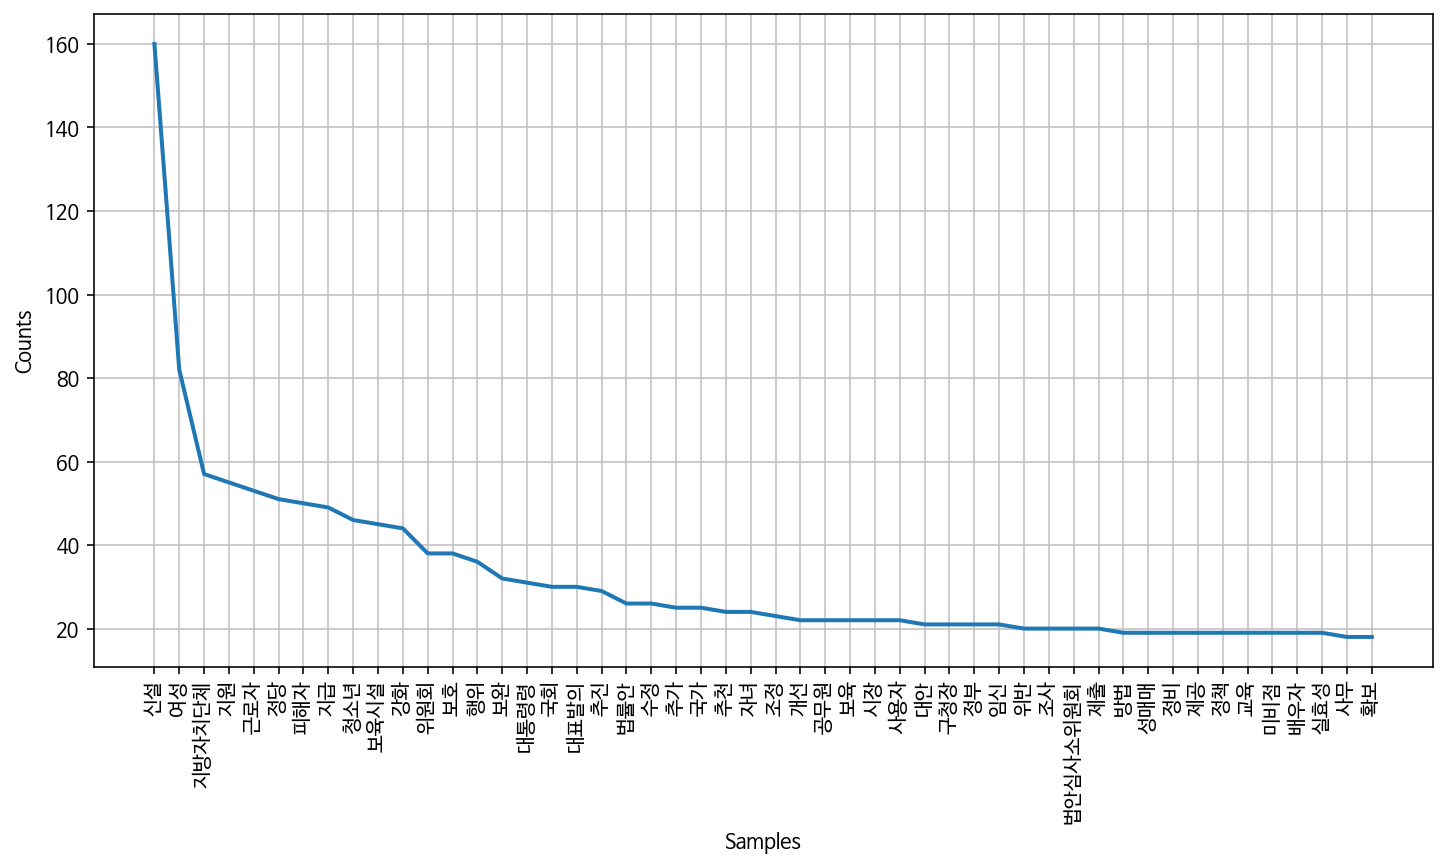

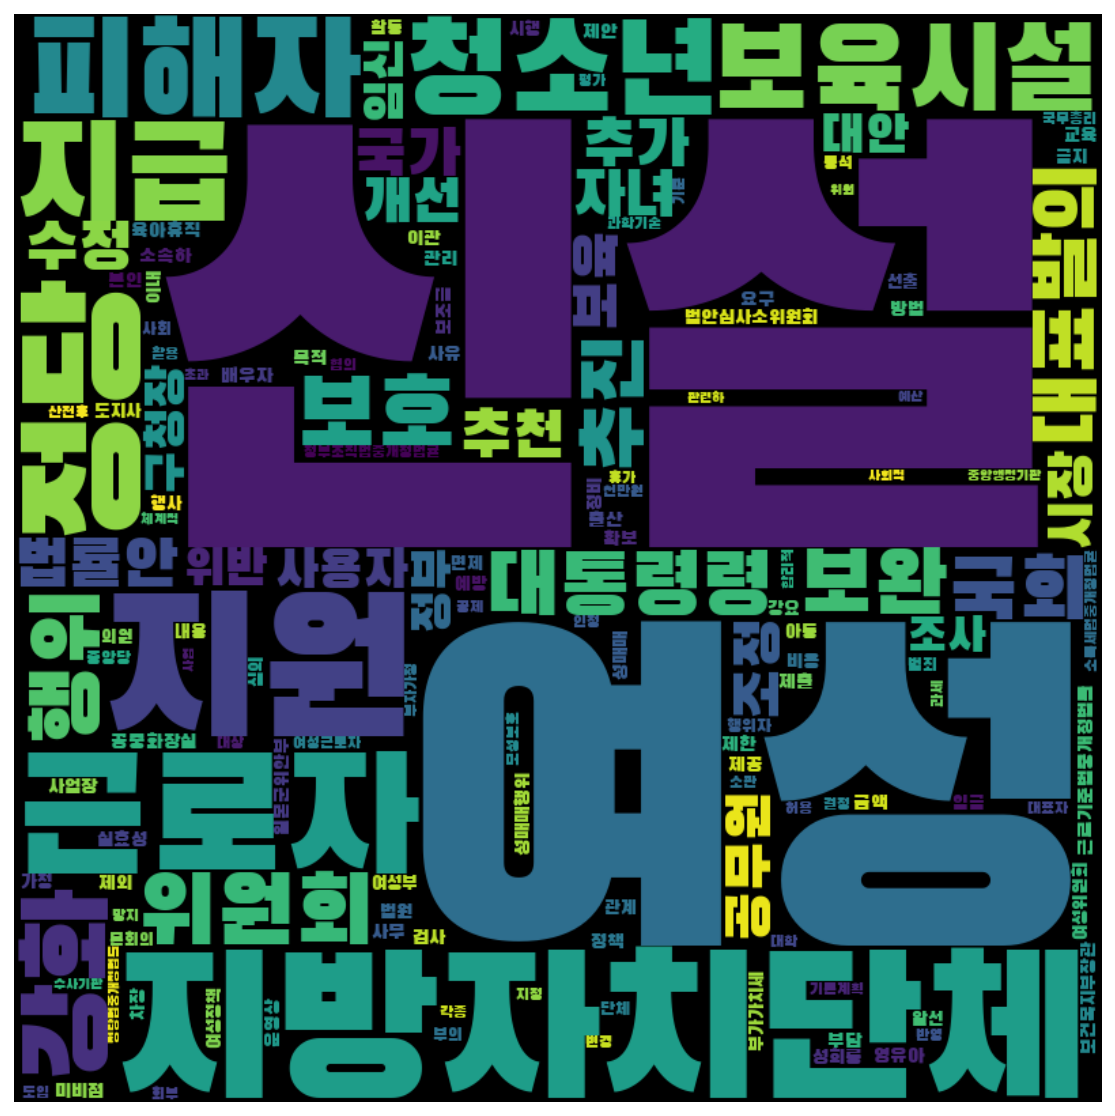

In [29]:
frewords_vis(gender_word)
wordcloud_vis(gender_word)